Mass ratio for  V1481.tbl  is ??
Periodogram peaks above a power of 0.25: []


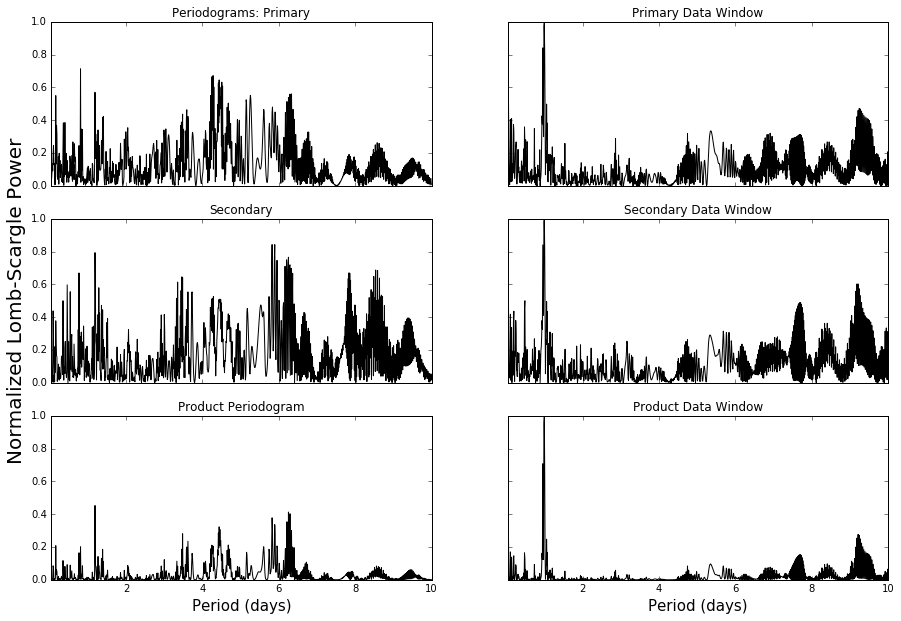

In [129]:
#import-libraries-and-data---------------------------------------------------------------------------------------#
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import lombscargle
from scipy import stats
%matplotlib inline
filename     = 'V1481.tbl'
system       = np.genfromtxt(filename, skip_header=1, usecols=(0, 1, 2))#, max_rows=11)

#use only first 11 data points to use ESO data, last 5 for APOGEE data

#define-variables------------------------------------------------------------------------------------------------#

JD, RVp, RVs = [datum[0] for datum in system], [datum[1] for datum in system], [datum[2] for datum in system]
JDp, JDs     = JD, JD
samples      = 1000
max_period   = 10

#dfine-functions-------------------------------------------------------------------------------------------------#

#This periodogram function was taken from Jake Vanderplas' article "Fast Lomb-Scargle Periodograms in Python"
def periodogram(t, rv, f):
    t = np.array(t)
    rv = np.array(rv)
# lower limit of periods range set to one hour
#    delta_t = np.inf 
#    for i in range(0, len(t)-2):
#        if t[i+1]-t[i] < delta_t and t[i+1]-t[i] != 0:
#            delta_t = t[i+1]-t[i]
    periods = np.linspace(0.04167, max_period, num = f)

    # convert period range into frequency range
    ang_freqs = 2 * np.pi / periods

    # compute the (unnormalized) periodogram
    # note pre-centering of y values!
    powers = lombscargle(t, rv - rv.mean(), ang_freqs)

    # normalize the power
    N = len(t)
    powers *= 2 / (N * rv.std() ** 2)
    return periods, powers

#slighty altered periodogram function, computes data window for a set of visits
def data_window(t, f):
    t = np.array(t)
#    delta_t = np.inf 
#    for i in range(0, len(t)-2):
#        if t[i+1]-t[i] < delta_t and t[i+1]-t[i] != 0:
#            delta_t = t[i+1]-t[i]
    periods = np.linspace(0.04167, max_period, num = f)

    # convert period range into frequency range
    ang_freqs = 2 * np.pi / periods

    # compute the (unnormalized) periodogram
    # note pre-centering of y values!
    powers = lombscargle(t, np.ones(len(t)), ang_freqs)

    # normalize the power
    N = len(t)
    powers *= 2 / N
    return periods, powers

#function computes and returns mass ratio and intercept
#def massRatio():
#    p =[datum[1] for datum in system if not np.isnan(datum[1]+datum[2])]
#    s =[datum[2] for datum in system if not np.isnan(datum[1]+datum[2])]
#    m,b = np.polyfit(s, p, 1)
#    return -m, b

#this function removes nan cells from the bad RV visits, and deletes the accompanying JD element 
#from a copy tied to the specific rv list
def adjustment(t, rv):
    adjusted_t = np.asarray(t)
    for i in range(0, len(t)-1):
        if i == len(rv):
            break
        if np.isnan(rv[i]):
            rv         = np.delete(rv, i)
            adjusted_t = np.delete(adjusted_t, i)
    return adjusted_t, rv

#function converts measurements in time into measurements in orbital phase (from 0-1)
#function is only useful after T and P have been determined
def phases(P, T, times):
    phased_Times = np.array([])
    for i in range(0, len(times)):
        phased_Times = np.append(phased_Times, ((times[i])-T)/P-int(((times[i])-T)/P))
        if phased_Times[i] < 0:
            phased_Times[i] = phased_Times[i]+1
    return phased_Times

#function finds local maxima above a specified cutoff power
def maxima(cutoff):
    power = y*y2
    maxima = np.array([])
    for i in range(1, len(power)-2):
        if power[i-1] < power[i] and power[i] > power[i+1] and power[i] > cutoff:
            maxima = np.append(maxima, x[i])
    return maxima

#now-do-things!--------------------------------------------------------------------------------------------------#

#check RV measurements for the need to be adjusted and adjust them if so
for i in range(0, len(JD)-1):
    if np.isnan(system[i][1]):
        JDp, RVp = adjustment(JD, RVp)
        break
        
for i in range(0, len(JD)-1):
    if np.isnan(system[i][2]):
        JDs, RVs = adjustment(JD, RVs)
        break
        
# plot the results
x, y  = periodogram(JDp, RVp, samples)
y2    = periodogram(JDs, RVs, samples)[1]
y3,y4 = data_window(JDp, samples)[1], data_window(JDs, samples)[1]

fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3, 2, sharex='col', sharey='row')
ax1.plot(x, y, 'k')
ax1.set_title('Periodograms: Primary')
ax1.set_xlim(1/24, max_period)
ax4.set_xlim(1/24, max_period)
ax2.plot(x, y2, 'k')
ax2.set_title('Secondary')
ax3.plot(x, y*y2, 'k')
ax3.set_title('Product Periodogram')
ax4.plot(x, y3, 'k')
ax4.set_title('Primary Data Window')
ax5.plot(x, y4, 'k')
ax5.set_title('Secondary Data Window')
ax6.plot(x, y3*y4, 'k')
ax6.set_title('Product Data Window')
ax3.set_xlabel('Period (days)', size='15')
ax6.set_xlabel('Period (days)', size='15')
ax2.set_ylabel('Normalized Lomb-Scargle Power', size='20')
fig.set_figheight(10)
fig.set_figwidth(15)
#plt.savefig(filename + ' periodogram.pdf')
print('Mass ratio for ', filename, ' is ??')
print('Periodogram peaks above a power of 0.25:',maxima(0.8))

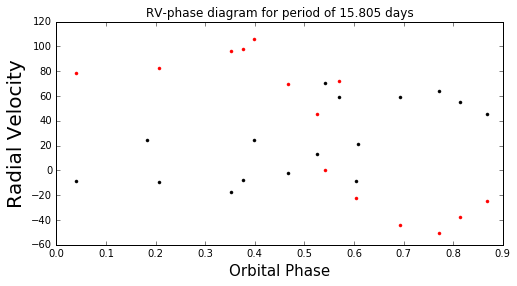

In [130]:
fig, ((ax1)) = plt.subplots(1,1, sharex='col', sharey='row')
ax1.plot(phases(maxima(0.3)[3], 0, JDp), RVp, 'k.')
ax1.plot(phases(maxima(0.3)[3], 0, JDs), RVs, 'r.')
ax1.set_title('RV-phase diagram for period of 15.805 days')
ax1.set_xlabel('Orbital Phase', size='15')
ax1.set_ylabel('Radial Velocity', size='20')
#fig.set_figheight(12)
fig.set_figwidth(8)
#plt.savefig(filename + ' RV-phase diagram.pdf')

0.359284288715
R squared:  0.415430965887  Standard error:  0.123031430474


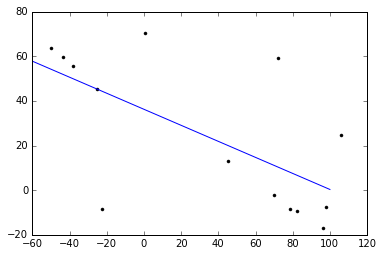

In [131]:
#below is the mass ratio calculation
p = [datum[1] for datum in system if not np.isnan(datum[1]+datum[2])]
s = [datum[2] for datum in system if not np.isnan(datum[1]+datum[2])]
slope, intercept, r_value, p_value, std_err = stats.linregress(s,p)
R2 = r_value**2
plt.plot(s, p, 'k.')
plt.plot(np.linspace(-60, 100, num=4), slope*np.linspace(-60, 100, num=4)+intercept)
print(-slope)
print('R squared: ', R2, ' Standard error: ', std_err)

In [132]:
mp = np.asarray(p).mean()
sp2 = ((p-mp)**2).sum()
sd_slope = std_err * np.sqrt(1./sp2)
print(sd_slope)

0.00102413453905


(2453657, 2453756)

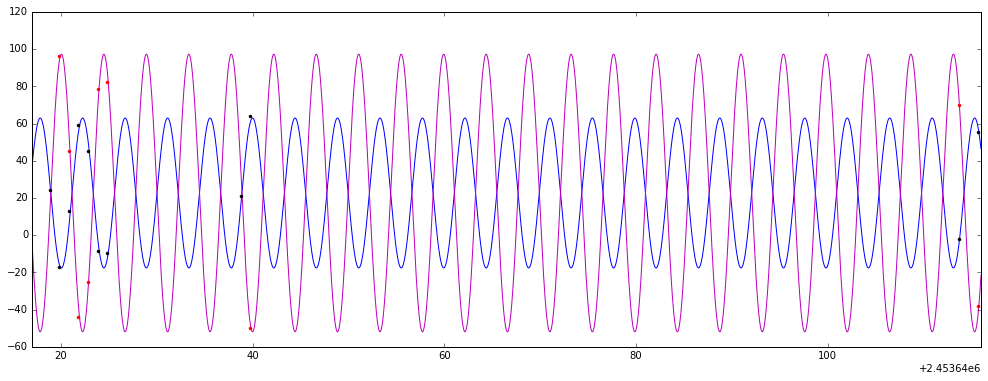

In [135]:
def RV(parameters): #function generates RV values plot from given parameters
    K1, P, T = parameters[0], parameters[1], parameters[2]
    e, w, y, t   = parameters[3], parameters[4], parameters[5], parameters[6]
    # t is some value of time, ultimately the independent variable, can bea single value or an array
    M = (2*np.pi/P)*(t-T) #Mean Anomaly is a function of time
    E1 = M + e*np.sin(M) + ((e**2)*np.sin(2*M)/2) #Eccentric Anomaly is a function of Mean Anomaly
    while True: #iteratively refines estimate of E1 from initial estimate
        E0 = E1
        M0 = E0 - e*np.sin(E0)
        E1 = E0 +(M-M0)/(1-e*np.cos(E0))
        if np.amax(E1-E0) < 1E-9:
            break
    nu = 2*np.arctan(np.sqrt((1 + e)/(1 - e))*np.tan(E1/2)) #True Anomaly is a function of Eccentric anomaly
    p, s = (K1*(np.cos(nu+w) + (e*np.cos(w)))+y), ((-K1/mass_ratio)*(np.cos(nu+w) + (e*np.cos(w)))+y)
    return p, s

Period = 4.433 #period in days determined first via periodogram
mass_ratio = 0.54

T = 30 #Time offset in days, boils down to a horizontal shift in RV. T is the 'zero' point
e = 0 #eccentricity (unitless)
w = 0 #longitude of periastron in radians
y = 22.7 #systemic velocity in km/s
t = np.linspace(2453640, 2456700, num = 100000) #provides independent variable values

#these parameters are star specific
K1= -40.3 #semamplitude in km/s
K2= -K1/mass_ratio

parameters = K1, Period, T, e, w, y, t

primary, secondary = RV(parameters)
plt.figure(figsize=(17,6))
plt.plot(t, primary)
plt.plot(t, secondary, 'm')

plt.plot(JDp, RVp, 'k.')
plt.plot(JDs, RVs, 'r.')
plt.xlim(2453657, 2453756) #uncomment for veiw of ESO points
#plt.xlim(2456606, 2456637) #uncomment for view of APOGEE points